<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import numpy as np
import random

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [57]:
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 30
batch_size = 16
noise_factor = 1

In [6]:
def add_noise(img):
    '''Add gaussian noise to images'''
    #VARIABILITY = 50
    #deviation = VARIABILITY*random.random()
    noise_factor=0.5
    noise = noise_factor * np.random.normal(0, 255., img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [13]:
def tuple_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [58]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = noise_factor * np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [59]:
#Clean data
train_datagen = ImageDataGenerator(rescale=1. / 255)

val_datagen_noisy = ImageDataGenerator(rescale=1. / 255,) 

train_generator_noisy = train_datagen_noisy.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator_noisy = val_datagen_noisy.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

#Adding noise
train_noisy = noisy_generator(train_generator)
val_noisy = noisy_generator(validation_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [60]:
sample_training_images, _ = next(train_noisy)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

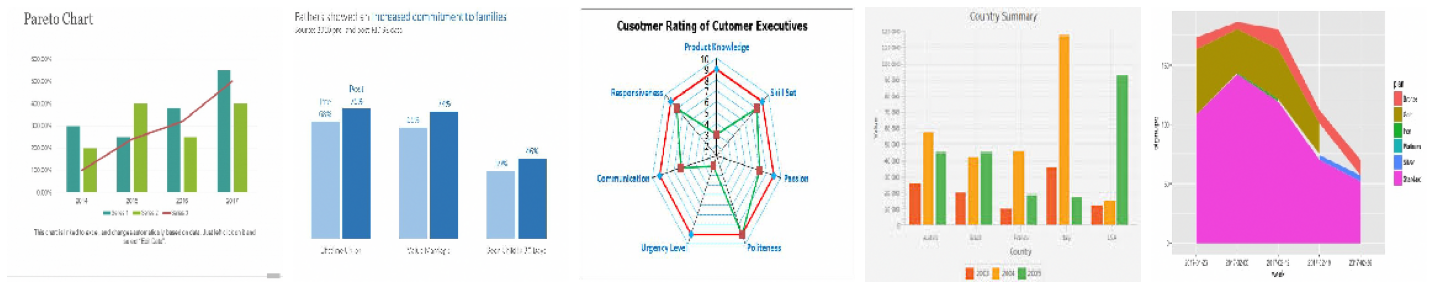

In [61]:
plotImages(sample_training_images[:5])

In [66]:
input_img = Input(shape=(img_width, img_height, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='softmax', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
autoencoder.fit(train_noisy,
                epochs=epochs,
                steps_per_epoch = train_generator.samples // batch_size,
                verbose=1,
                validation_data= val_noisy, 
                validation_steps= validation_generator.samples // batch_size)

Epoch 1/30
35/35 [==============================] - 11s 321ms/step - loss: 2.9835 - accuracy: 0.4034 - val_loss: 2.9397 - val_accuracy: 0.1713
Epoch 2/30
35/35 [==============================] - 11s 320ms/step - loss: 2.9754 - accuracy: 0.4409 - val_loss: 2.9323 - val_accuracy: 0.8094
Epoch 3/30
35/35 [==============================] - 11s 326ms/step - loss: 2.9777 - accuracy: 0.4116 - val_loss: 2.9345 - val_accuracy: 0.8015
Epoch 4/30
 1/35 [..............................] - ETA: 0s - loss: 2.8531 - accuracy: 0.8374

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f2c10eddc18>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


32/35 [==========================>...] - ETA: 0s - loss: 2.9652 - accuracy: 0.4507

KeyboardInterrupt: ignored

In [37]:
X, y = next(val_noisy)

In [38]:
decode_img = autoencoder.predict(X)

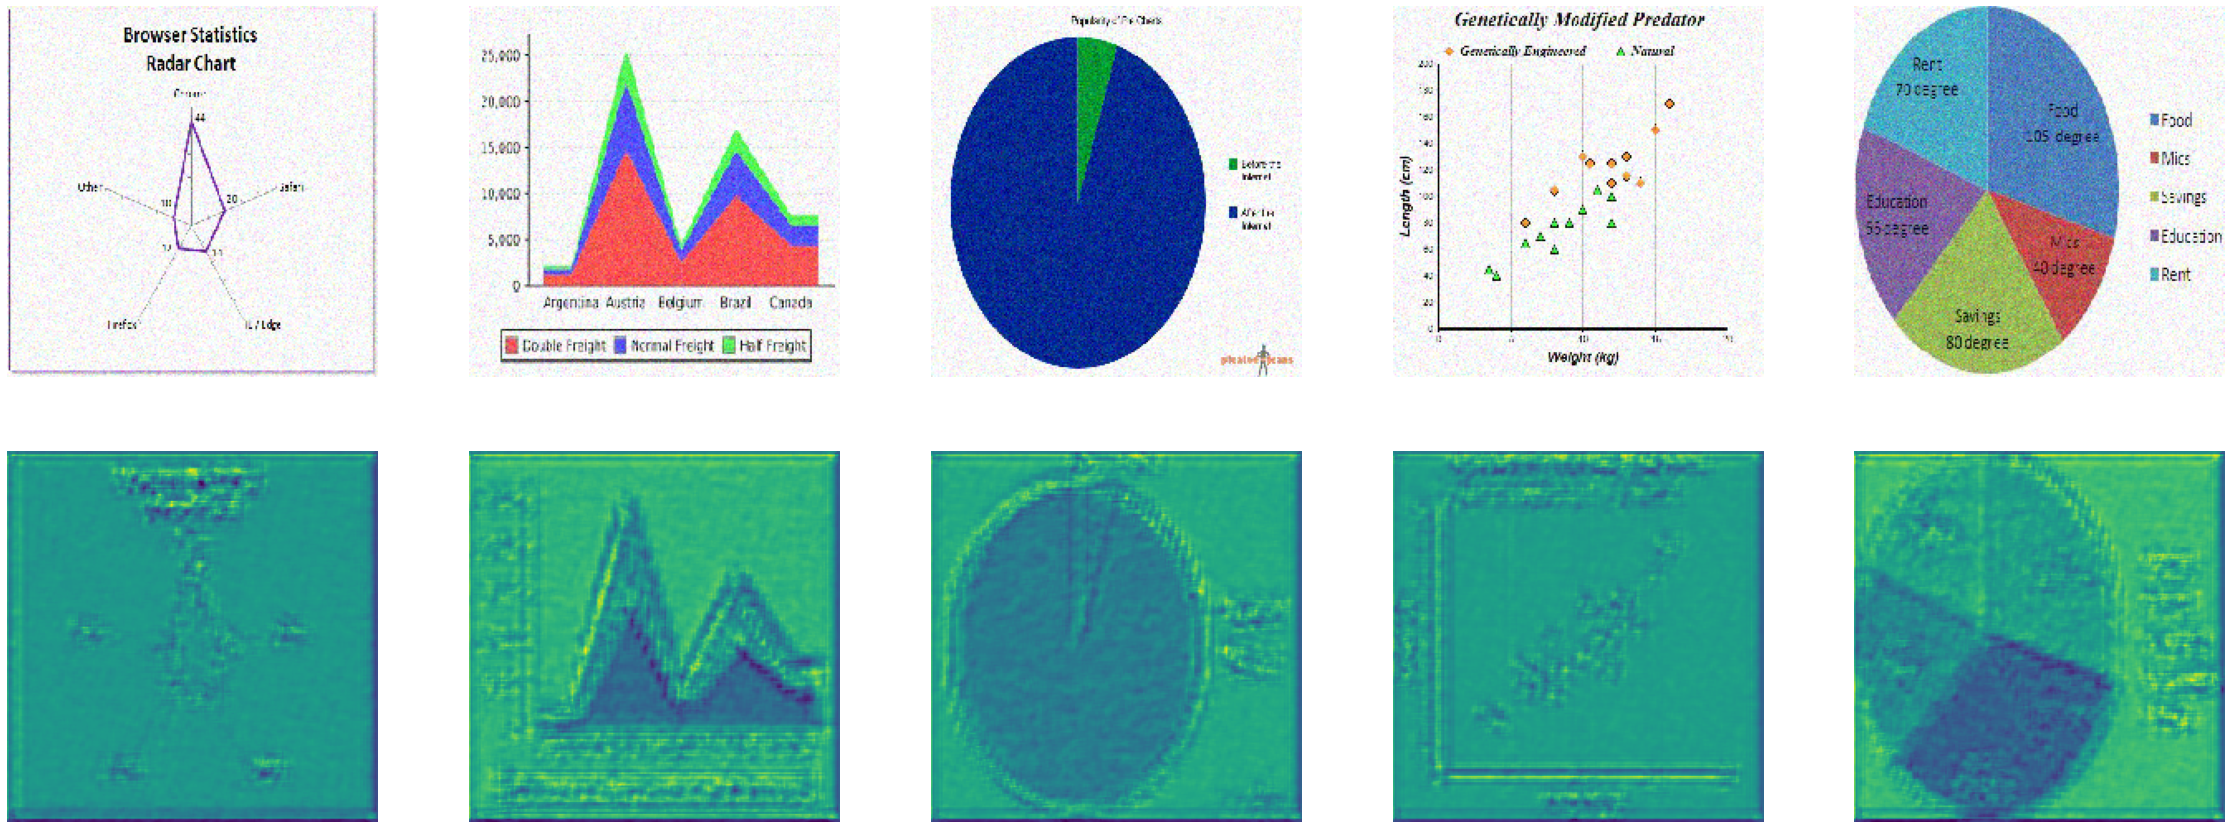

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf


n = 5

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i])
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(np.squeeze(decode_img[i]))
    ax.axis('off')

plt.show()

TypeError: ignored

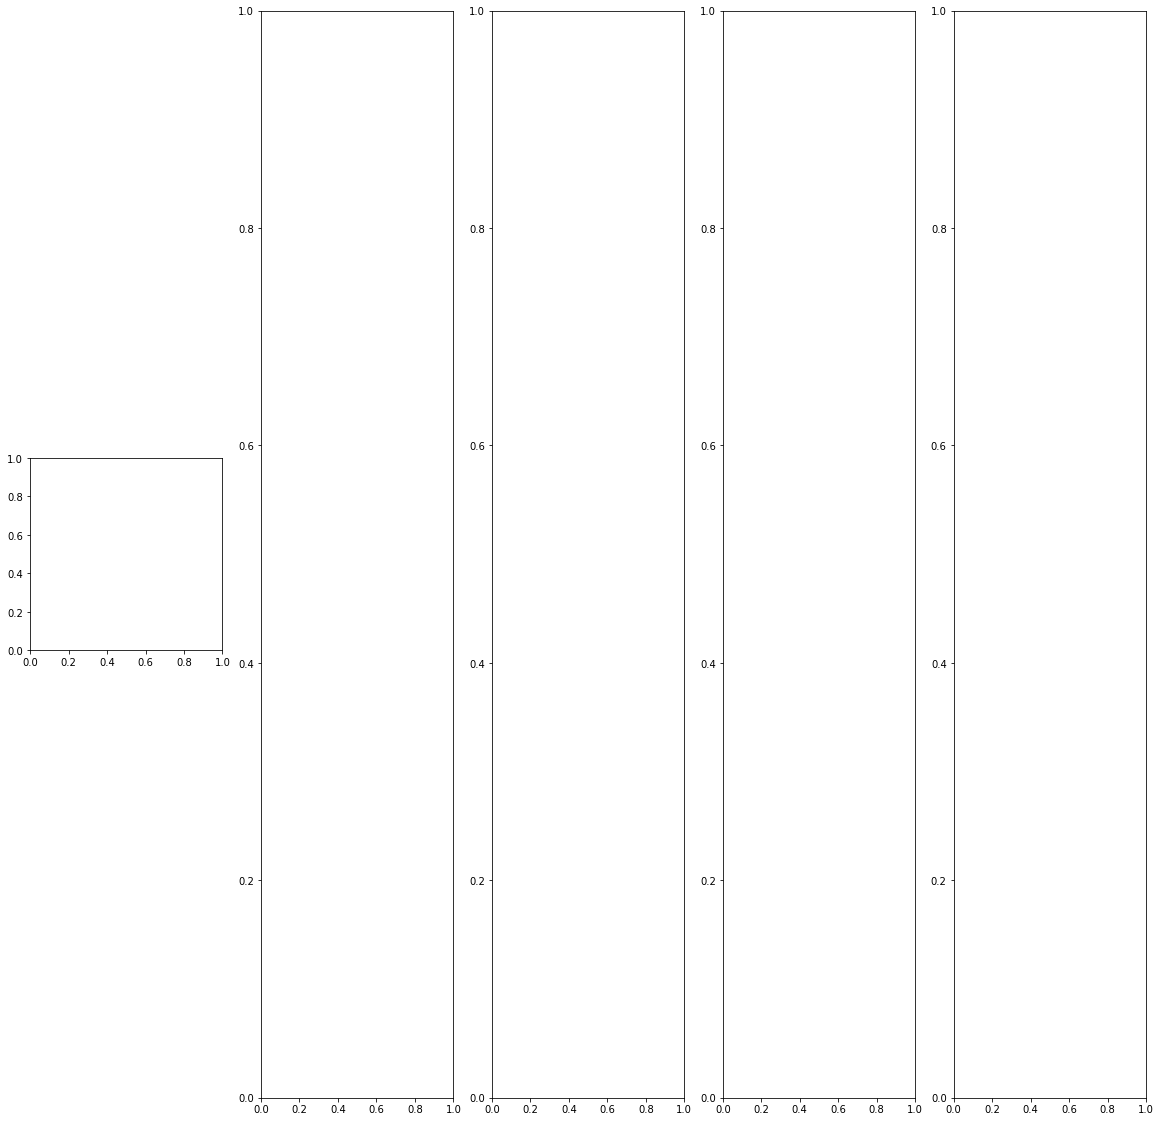

In [43]:
plotImages(decode_img[:5])